<center><h1>Time Series Analysis of Covid-19</h1>
    Stephen Webb</center>
    
This is a time series analysis of the spread of covid-19, based on data from Johns Hopkins University, <url> https://github.com/CSSEGISandData/COVID-19</url>, subject to this copyright notice:

>This GitHub repo and its contents herein, including all data, mapping, and analysis, copyright 2020 Johns Hopkins University, all rights reserved, is provided to the public strictly for educational and academic research purposes.  The Website relies upon publicly available data from multiple sources, that do not always agree. The Johns Hopkins University hereby disclaims any and all representations and warranties with respect to the Website, including accuracy, fitness for use, and merchantability.  Reliance on the Website for medical guidance or use of the Website in commerce is strictly prohibited.

The goal here is to try to understand the logistic growth curves of the various afflicted regions, and try to find similarities with the various US states to get a feel for how bad this could get and how long it would take to get there.

In [1]:
# Standard imports
import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

# using inline, have to set the figure bigger
%matplotlib inline

# set figure parameters so they look pretty
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (9.5, 6),
         'axes.labelsize': 12,
         'axes.titlesize': 14,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12,
         'axes.spines.right' : False,
         'axes.spines.left' : False,
         'axes.spines.top' : False,
         'axes.spines.bottom' : False}
pylab.rcParams.update(params)

# I like to have more colors than what are available, so define tableau20 colors:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Some Useful Functions

We'll need some of these for data fitting later on.

In [2]:
def logistic_func(t, L, k, t0):
    return L/(1. + np.exp(-k*(t-t0)) )

def exp_func(t, A, k, t0):
    return A * np.exp(k * (t - t0))

## Data Exploration

Read in and look at the available data.

In [3]:
ts_data = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'

cv19_confirmed = pd.read_csv(ts_data+'time_series_19-covid-Confirmed.csv')
cv19_deaths    = pd.read_csv(ts_data+'time_series_19-covid-Deaths.csv')
cv19_recovered = pd.read_csv(ts_data+'time_series_19-covid-Recovered.csv')

# We want to use the dates as data in rows, so use the melt function
cv19_confirmed = cv19_confirmed.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="Date", 
        value_name="Value")
cv19_deaths = cv19_deaths.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="Date", 
        value_name="Value")
cv19_recovered = cv19_recovered.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="Date", 
        value_name="Value")

# Convert the dates to datetime
cv19_confirmed['Date'] = pd.to_datetime(cv19_confirmed.Date)
cv19_deaths['Date'] = pd.to_datetime(cv19_deaths.Date)
cv19_recovered['Date'] = pd.to_datetime(cv19_recovered.Date)

# Take a look at the data
cv19_confirmed.head()
cv19_deaths.head()
cv19_recovered.head()

,Province/State,Country/Region,Lat,Long,Date,Value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2
1,NaN,Japan,36.0000,138.0000,2020-01-22,2
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


,Province/State,Country/Region,Lat,Long,Date,Value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


,Province/State,Country/Region,Lat,Long,Date,Value
0,NaN,Thailand,15.0000,101.0000,2020-01-22,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


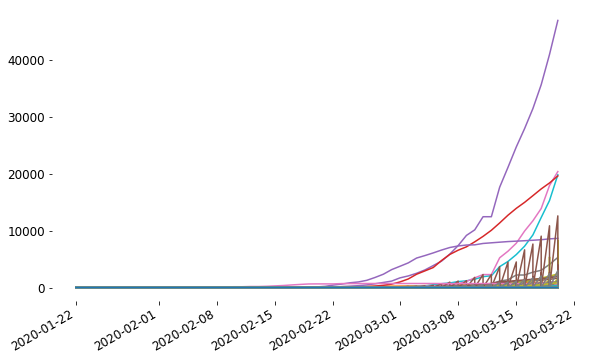

In [4]:
# Let's just look at a plot of the confirmed cases worldwide by date
fig, ax = plt.subplots();
for country in cv19_confirmed['Country/Region'].unique():
    if country != 'China':
        subframe = cv19_confirmed.loc[cv19_confirmed['Country/Region'] == country]
        ax.plot(subframe['Date'], subframe['Value']);
    
fig.autofmt_xdate()

fig.show();

In [5]:
# now, break out the data for the US versus the rest of the world
cv19_confirmed_US = cv19_confirmed.loc[cv19_confirmed['Country/Region'] == 'US']
cv19_confirmed_else = cv19_confirmed.loc[cv19_confirmed['Country/Region'] != 'US']
cv19_deaths_US = cv19_deaths.loc[cv19_deaths['Country/Region'] == 'US']
cv19_deaths_else = cv19_deaths.loc[cv19_deaths['Country/Region'] != 'US']
cv19_recovered_US = cv19_recovered.loc[cv19_recovered['Country/Region'] == 'US']
cv19_recovered_else = cv19_recovered.loc[cv19_recovered['Country/Region'] != 'US']

We want to look at the running total number of infections, to look for a possible inflection point.

In [6]:
# a useful function
def compute_total_confirmed(df):
    """Computes the totals on a fixed date for a dataframe with multiple regions
    
    Returns:
    unique_dates : list
    total_values : list"""
    
    unique_dates = df['Date'].unique()
    total_values = [np.sum(df.loc[df['Date'] == date].Value) for date in unique_dates]
    
    return np.array(unique_dates), np.array(total_values)

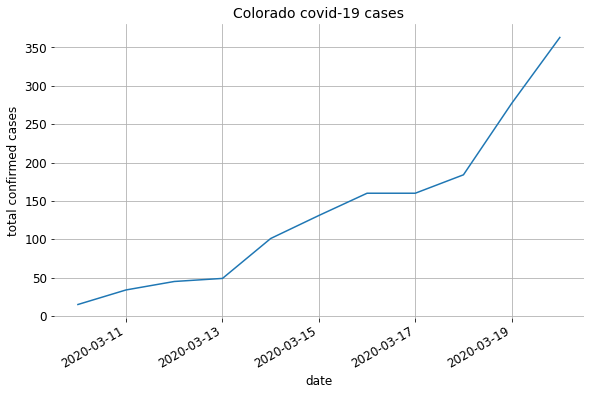

In [85]:
state = 'Colorado'
unique_dates, total_values = compute_total_confirmed(
    cv19_confirmed_US.loc[cv19_confirmed_US['Province/State'] == state]
        )

outbreak = np.where(np.array(total_values) > 0)[0]

fig, ax = plt.subplots()
ax.plot(unique_dates[outbreak], total_values[outbreak])
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('total confirmed cases')
ax.set_title('{} covid-19 cases'.format(state))
fig.autofmt_xdate();

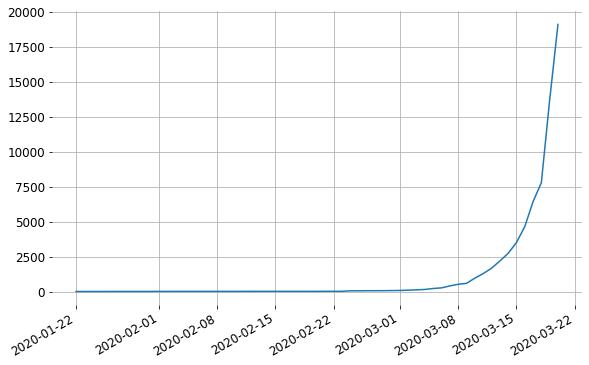

In [86]:
unique_dates, total_confirmed_US = compute_total_confirmed(cv19_confirmed_US)
fig, ax = plt.subplots()
ax.plot(unique_dates, total_confirmed_US)
ax.grid()
fig.autofmt_xdate()

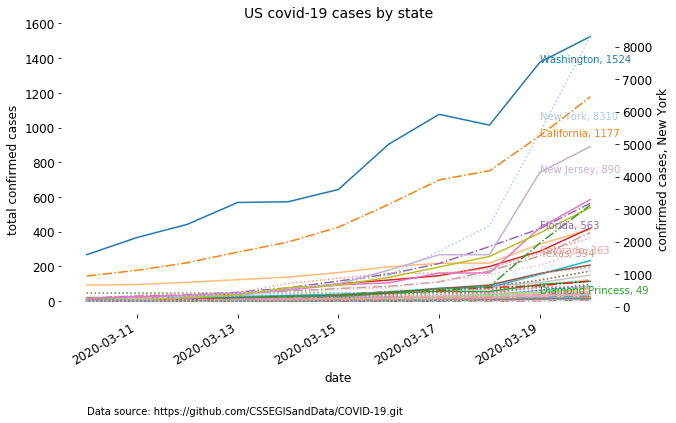

In [87]:
# Let's look at the totals in each state

states = cv19_confirmed_US['Province/State'].unique()

fig, ax = plt.subplots();
data_dict = {}
for state in states:
    # Cut out the county-level data, which all has the form "COUNTY NAME, STATE ABBR."
    if ',' in state:
        pass
    else:
        dates, totals = compute_total_confirmed(
            cv19_confirmed_US.loc[cv19_confirmed_US['Province/State'] == state]
                )
        # Only plot dates where there's disease
        outbreak_dates = np.where(np.array(total_values) > 0)[0]
        data_dict[state] = [dates[outbreak_dates], totals[outbreak_dates]]

tab_num = 0

# List of states to label
key_states = ['New York', 'Florida', 'Colorado', 'Washington', 
              'California', 'Washington DC', 
              'New Jersey', 'Texas', 'Diamond Princess']
for state in data_dict.keys():
    
    dates, totals = data_dict[state]
    #ax.plot(data_dict[state][0], data_dict[state][1], label=state)
    label_date = dates[-2]
    label_height = totals[-2]
    
    lines = ['-', ':', '-.']
    
    # New York is the epicenter and messes up the plot, so split it off
    # onto its own axis
    if state == 'New York':
        ax2 = ax.twinx()
        ax2.set_ylabel('confirmed cases, New York')
        if state in key_states:
            ax2.plot(dates, totals, label=state, color=tableau20[tab_num%20], linestyle=lines[tab_num%3])
            ax2.annotate(state+', '+str(totals[-1]), xy=(label_date, label_height+400), 
                         color=tableau20[tab_num%20], fontsize=10);
        else:
            ax2.plot(dates, totals, color=tableau20[tab_num%20], linestyle=lines[tab_num%3])

    else:
        if state in key_states:
            ax.plot(dates, totals, label=state, color=tableau20[tab_num%20], linestyle=lines[tab_num%3])
            ax.annotate(state+', '+str(totals[-1]), xy=(label_date, label_height), 
                        color=tableau20[tab_num%20], fontsize=10);
        else:
            ax.plot(dates, totals, color=tableau20[tab_num%20], linestyle=lines[tab_num%3])

    tab_num += 1
    
ax.text(dates[0], -650, "Data source: https://github.com/CSSEGISandData/COVID-19.git", fontsize=10)  

        
ax.set_xlabel('date')
ax.set_ylabel('total confirmed cases')
ax.set_title('US covid-19 cases by state')

fig.autofmt_xdate()
#fig.legend()
fig.tight_layout();